# Document AI: Fine-tuning Donut for document-parsing using Hugging Face Transformers 

In this blog, you will learn how to fine-tune [Donut-base](https://huggingface.co/naver-clova-ix/donut-base) for document-understand/document-parsing using Hugging Face Transformers. Donut is a new document-understanding model achieving state-of-art performance with an MIT-license, which allows it to be used for commercial purposes compared to other models like LayoutLMv2/LayoutLMv3. 
We are going to use all of the great features from the Hugging Face ecosystem, like model versioning and experiment tracking.

We will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts, including their OCR. More information for the dataset can be found at the [repository](https://github.com/zzzDavid/ICDAR-2019-SROIE).

You will learn how to:


1. [Setup Development Environment](#1-setup-development-environment)
2. [Load SROIE dataset](#2-load-sroie-dataset)
3. [Prepare dataset for Donut](#3-prepare-dataset-for-donut)
4. [Fine-tune and evaluate Donut model](#4-fine-tune-and-evaluate-donut-model)


Before we can start, make sure you have a [Hugging Face Account](https://huggingface.co/join) to save artifacts and experiments. 

## Quick intro: Document Understanding Transformer (Donut) by ClovaAI

Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding. It doesn't require an OCR engine to process scanned documents but is achieving state-of-the-art performances on various visual document understanding tasks, such as visual document classification or information extraction (a.k.a. document parsing). 
Donut is a multimodal sequence-to-sequence model with a vision encoder ([Swin Transformer](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/swin#overview)) and text decoder ([BART](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/bart)). The encoder receives the images and computes it into an embedding, which is then passed to the decoder, which generates a sequence of tokens.

![donut](../assets/donut.png)

* Paper: https://arxiv.org/abs/2111.15664
* Official repo:  https://github.com/clovaai/donut

--- 

Now we know how Donut works, so let's get started. 🚀

_Note: This tutorial was created and run on a p3.2xlarge AWS EC2 Instance including a NVIDIA V100._


## 1. Setup Development Environment

Our first step is to install the Hugging Face Libraries, including transformers and datasets. Running the following cell will install all the required packages.


In [ ]:
!pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard 

In [ ]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account, you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load SROIE dataset

We will use the [SROIE](https://github.com/zzzDavid/ICDAR-2019-SROIE) dataset a collection of 1000 scanned receipts including their OCR, more specifically we will use the dataset from task 2 "Scanned Receipt OCR". The available dataset on Hugging Face ([darentang/sroie](https://huggingface.co/datasets/darentang/sroie)) is not compatible with Donut. Thats why we will use the original dataset together with the `imagefolder` feature of `datasets` to load our dataset. Learn more about loading image data [here](https://huggingface.co/docs/datasets/v2.4.0/en/image_load#load-image-data).

_Note: The test data for task2 is sadly not available. Meaning that we end up only with 624 images._

First, we will clone the repository, extract the dataset into a separate folder and remove the unnecessary files.


In [ ]:
%%bash 
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Now we have two folders inside the `data/` directory. One contains the images of the receipts and the other contains the OCR text. The nex step is to create a `metadata.json` file that contains the information about the images including the OCR-text. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below.

```json
{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "text": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image, which will later be used for creating the Donut specific format.

In [30]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():    
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file
      
# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)

Good Job! Now we can load the dataset using the `imagefolder` feature of `datasets`.

In [31]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list

In [ ]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Now, lets take a closer look at our dataset

Random sample is 110
OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}


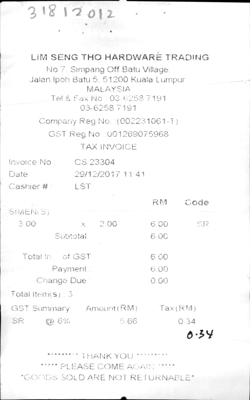

In [33]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))


## 3. Prepare dataset for Donut

As we learned in the introduction, Donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the `"text"` based on the image we pass it. Similar to NLP tasks, we have to tokenize and preprocess the text. 
Before we can tokenize the text, we need to transform the JSON string into a Donut compatible document. 

**current JSON string**
```json
{"company": "ADVANCO COMPANY", "date": "17/01/2018", "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR", "total": "7.00"}
```

**Donut document**
```json
<s></s><s_company>ADVANCO COMPANY</s_company><s_date>17/01/2018</s_date><s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address><s_total>7.00</s_total></s>
```

To easily create those documents the ClovaAI team has created a [json2token](https://github.com/clovaai/donut/blob/master/donut/model.py#L497) method, which we extract and then apply.

In [34]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")


100%|██████████| 626/626 [00:48<00:00, 12.84ex/s]


Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


The next step is to tokenize our text and encode the images into tensors. Therefore we need to load `DonutProcessor`, add our new special tokens and adjust the size of the images when processing from `[1920, 2560]` to `[720, 960]` to need less memory and have faster training.

In [35]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

Now, we can prepare our dataset, which we will use for the training later.


In [37]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
        
    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

100%|██████████| 626/626 [01:46<00:00,  5.86ex/s]


In [38]:
# from datasets import load_from_disk
# from transformers import DonutProcessor

## COMMENT IN in case you want to save the processed dataset to disk in case of error later
# processed_dataset.save_to_disk("processed_dataset")
# processor.save_pretrained("processor")

## COMMENT IN in case you want to load the processed dataset from disk in case of error later
# processed_dataset = load_from_disk("processed_dataset")
# processor = DonutProcessor.from_pretrained("processor")


The last step is to split the dataset into train and validation sets.

In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

## 4. Fine-tune and evaluate Donut model

After we have processed our dataset, we can start training our model. Therefore we first need to load the [naver-clova-ix/donut-base](https://huggingface.co/naver-clova-ix/donut-base) model with the `VisionEncoderDecoderModel` class. The `donut-base` includes only the pre-trained weights and was introduced in the paper [OCR-free Document Understanding Transformer](https://arxiv.org/abs/2111.15664) by Geewok et al. and first released in [this repository](https://github.com/clovaai/donut).

In addition to loading our model, we are resizing the `embedding` layer to match newly added tokens and adjusting the `image_size` of our encoder to match our dataset. We are also adding tokens for inference later.

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

Before we can start our training we need to define the hyperparameters (`Seq2SeqTrainingArguments`) we want to use for our training. We are leveraging the [Hugging Face Hub](https://huggingface.co/models) integration of the `Seq2SeqTrainer` to automatically push our checkpoints, logs and metrics during training into a repository.

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

We can start our training by using the `train` method of the `Seq2SeqTrainer`.

In [ ]:
# Start training
trainer.train()

After our training is done we also want to save our processor to the Hugging Face Hub and create a model card. 

In [ ]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

We sucessfully trainied our model now lets test it and then evaulate accuracy of it. 

Reference:
 {'total': '9.30', 'date': '26/11/2017', 'company': 'SANYU STATIONERY SHOP', 'address': 'NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM'}
Prediction:
 {'total': '9.30', 'date': '26/11/2017', 'company': 'SANYU STATIONERY SHOP', 'address': 'NO. 31G&33G, JALAN SETIA INDAH X,U13/X 40170 SETIA ALAM'}


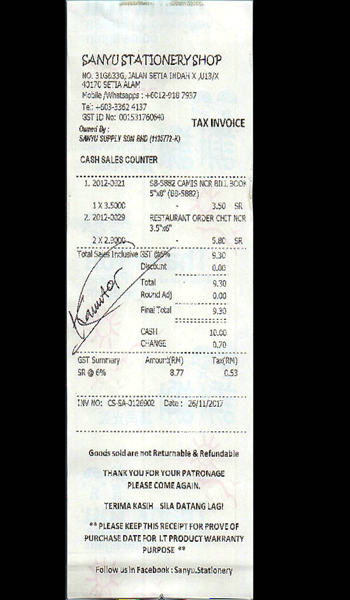

In [14]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
model = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 50)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))


Nice 😍🔥 Our fine-tuned parsed the document correctly and extracted the right values. Our next step is to evalute our model on the test set. Since the model itself is a seq2seq is not that straightforward to evaluate. 

To keep things simple we will use accuracy as metric and compare the predicted value for each key in the dictionary to see if they are equal. This evaluation technique is biased/simple sincne only exact matches are truthy, e.g. if the model is not detecting a "whitespace" as in the example above it will not be counted truthy. 

In [30]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")

100%|██████████| 63/63 [02:05<00:00,  2.00s/it]

Accuracy: 75.0%


Our model achieves an accuracy of `75%` on the test set. 

_Note: The evaluation we did was very simple and only valued exact string matches as "truthy" for each key of the dictonary, is a big bias for the evaluation. Meaning that a accuracy of `75%` is pretty good._

Our first inference test is an excellent example of why this metric is biased. There the model predicted for the `address` the value `NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM` and the ground truth was `'NO. 31G&33G, JALAN SETIA INDAH X,U13/X 40170 SETIA ALAM'`, where the only difference is the ` ` whitespace in between `X` and `,U13/X`. 
In our evaluation loop, this was not counted as a truthy value.
